In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from pylightgbm.models import GBMClassifier
import lightgbm as lgb


from sklearn import ensemble, metrics, preprocessing
from sklearn.cross_validation import KFold, train_test_split, StratifiedKFold, cross_val_score
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [278]:
test = pd.read_csv('./files/x_test.csv', sep=';')
train = pd.read_csv('./files/x_train.csv', sep=';')
train_y = pd.read_csv('./files/y_train.csv', header = None)

Add new features

In [281]:
'maxPlayerLevel - максимальный уровень игры, который прошел игрок'
'numberOfAttemptedLevels - количество уровней, которые попытался пройти игрок'
'attemptsOnTheHighestLevel - число попыток, сделанных на самом высоком уровне'
'totalNumOfAttempts - общее число попыток'
'averageNumOfTurnsPerCompletedLevel - среднее количество ходов, выполненных на успешно пройденных уровнях'
'doReturnOnLowerLevels - делал ли игрок возвраты к игре на уже пройденных уровнях'
'numberOfBoostersUsed - количество использованных бустеров'
'fractionOfUsefullBoosters - количество бустеров, использованных во время успешных попыток (игрок прошел уровнь)'


train['Star1'] = train.totalStarsCount/train.numberOfAttemptedLevels
train['Lvl_num_att'] = train.maxPlayerLevel/train.numberOfAttemptedLevels
train['Att_high_lvl'] = train.totalNumOfAttempts/train.attemptsOnTheHighestLevel
train['Att_turns'] = train.numberOfAttemptedLevels/train.averageNumOfTurnsPerCompletedLevel
train['Boost'] = train.numberOfBoostersUsed/train.fractionOfUsefullBoosters
train['Turn_boost'] = train.averageNumOfTurnsPerCompletedLevel/train.fractionOfUsefullBoosters
train['Score_Stars'] = (train.totalScore/train.totalStarsCount)/train.numberOfDaysActuallyPlayed
train['Score_bonuse'] = (train.totalScore/train.totalBonusScore)/train.numberOfDaysActuallyPlayed
train['ScoreAvg'] = train.totalScore/train.numberOfDaysActuallyPlayed
train['AverageNumOfTurnsAvg'] = train.averageNumOfTurnsPerCompletedLevel/train.numberOfDaysActuallyPlayed
train['Score_level'] = train.totalScore/train.maxPlayerLevel
train['Score_level_att'] = train.totalScore/train.totalNumOfAttempts
train['NumberOfBooster_att'] =train.numberOfBoostersUsed/train.totalNumOfAttempts

test['Star1'] = test.totalStarsCount/test.numberOfAttemptedLevels
test['Lvl_num_att'] = test.maxPlayerLevel/test.numberOfAttemptedLevels
test['Att_high_lvl'] = test.totalNumOfAttempts/test.attemptsOnTheHighestLevel
test['Att_turns'] = test.numberOfAttemptedLevels/test.averageNumOfTurnsPerCompletedLevel
test['Boost'] = test.numberOfBoostersUsed/test.fractionOfUsefullBoosters
test['Turn_boost'] = test.averageNumOfTurnsPerCompletedLevel/test.fractionOfUsefullBoosters
test['Score_Stars'] = (test.totalScore/test.totalStarsCount)/test.numberOfDaysActuallyPlayed
test['Score_bonuse'] = (test.totalScore/test.totalBonusScore)/test.numberOfDaysActuallyPlayed
test['ScoreAvg'] = test.totalScore/test.numberOfDaysActuallyPlayed
test['AverageNumOfTurnsAvg'] = test.averageNumOfTurnsPerCompletedLevel/test.numberOfDaysActuallyPlayed
test['Score_level'] = test.totalScore/test.maxPlayerLevel
test['Score_level_att'] = test.totalScore/test.totalNumOfAttempts
test['NumberOfBooster_att'] =test.numberOfBoostersUsed/test.totalNumOfAttempts

In [282]:
feat_names = train.columns

In [283]:
train = train.fillna(0, axis=0)
train = train.replace('inf',0, axis=0)

test = test.fillna(0, axis=0)
test = test.replace('inf',0, axis=0)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:3416: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warn('the "axis" argument is deprecated and will be removed in'


In [284]:
train.shape


(25289, 25)

Scale data

In [285]:
cat = train.doReturnOnLowerLevels
cat_test = test.doReturnOnLowerLevels
train.drop('doReturnOnLowerLevels', axis=1, inplace=True)
test.drop('doReturnOnLowerLevels', axis=1, inplace=True)

In [286]:
scaler = preprocessing.StandardScaler().fit(train.values)

In [287]:
train_scaled = scaler.transform(train.values)
test_scaled = scaler.transform(test.values)

In [288]:
train_scaled = np.hstack([train_scaled, cat.reshape(len(cat),1)])
test_scaled = np.hstack([test_scaled, cat_test.reshape(len(cat_test),1)])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


Cross validation - KFold

In [13]:
skf = StratifiedKFold(np.array(train_y).ravel(), 5,  random_state=0)

In [289]:
p = []
for train_index, test_index in skf:
    xgb_model = xgb.XGBClassifier(seed=0, max_depth=4, learning_rate=0.01, n_estimators=900, silent=True, objective='binary:logistic',
subsample=0.7, gamma=5, colsample_bylevel=0.6, max_delta_step=1, min_child_weight=10).fit(np.array(train_scaled)[train_index],np.array(train_y)[train_index].ravel(), eval_metric='logloss')
    predictions = xgb_model.predict_proba(np.array(train_scaled)[test_index])
    actuals = np.array(train_y)[test_index]
    print('log_loss: ', metrics.log_loss(actuals, predictions[:,1]))
    p.append(metrics.log_loss(actuals, predictions[:,1]))
print('Mean: ', np.mean(p))

log_loss:  0.385324768944
log_loss:  0.376620456233
log_loss:  0.371014136203
log_loss:  0.396082685333
log_loss:  0.370846225003
Mean:  0.379977654343


Model

In [292]:
xgb_model = xgb.XGBClassifier(max_depth=4, learning_rate=0.01, n_estimators=900, silent=True, objective='binary:logistic',
subsample=0.7, gamma=5, colsample_bylevel=0.6, max_delta_step=1, min_child_weight=10).fit(train_scaled,train_y)
predictions = xgb_model.predict_proba(test_scaled)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [297]:
pd.Series(predictions[:,1]).to_csv('XGBClassifier_new_tune_feature.csv', index=False, sep=';', header=None)

(array([ 5473.,  2574.,  1731.,   755.,   816.,   758.,   652.,   561.,
          579.,   524.,   430.,   440.,   374.,   344.,   312.,   261.,
          270.,   236.,   259.,   307.,   283.,   295.,   288.,   241.,
          258.,   237.,   240.,   223.,   185.,   218.,   238.,   259.,
          246.,   236.,   275.,   274.,   309.,   311.,   350.,   319.,
          331.,   333.,   288.,   302.,   190.,   154.,   131.,   148.,
          184.,   287.]),
 array([ 0.01879109,  0.03806067,  0.05733025,  0.07659982,  0.0958694 ,
         0.11513898,  0.13440855,  0.15367813,  0.17294771,  0.19221728,
         0.21148686,  0.23075644,  0.25002601,  0.26929559,  0.28856517,
         0.30783474,  0.32710432,  0.3463739 ,  0.36564347,  0.38491305,
         0.40418263,  0.4234522 ,  0.44272178,  0.46199136,  0.48126093,
         0.50053051,  0.51980009,  0.53906966,  0.55833924,  0.57760882,
         0.5968784 ,  0.61614797,  0.63541755,  0.65468713,  0.6739567 ,
         0.69322628,  0.7124958

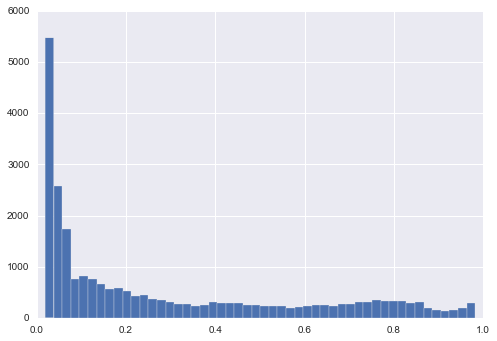

In [295]:
plt.hist(predictions[:,1], bins=50)